In [22]:
# Imports
import warnings
import numpy as np
import pandas as pd
import pyfixest as pf
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadstat
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.formula.api as smf
import statsmodels.api as sm
from typing import List
from stargazer.stargazer import Stargazer

In [23]:
cps= pd.read_csv("https://osf.io/download/4ay9x/")
#-----------------------------------------------------------#
# Sample Selection and Creating New Data #
# ----------------------------------------------------------#
cps = cps.query("uhours>=20 & earnwke>0 & age>=24 & age<=64")
# Create variables
cps["female"] = (cps.sex == 2).astype(int)
cps["w"] = cps["earnwke"] / cps["uhours"]
cps["lnw"] = np.log(cps["w"])
# Add demographic variables
cps["white"] = (cps["race"] == 1).astype(int)
cps["afram"] = (cps["race"] == 2).astype(int)
cps["asian"] = (cps["race"] == 4).astype(int)
cps["hisp"] = (cps["ethnic"].notna()).astype(int)
cps["othernonw"] = ( (cps["white"] == 0) & (cps["afram"] == 0) & (cps["asian"] == 0) & (cps["hisp"]== 0) ).astype(int)
cps["nonUSborn"] = ( (cps["prcitshp"] == "Foreign Born, US Cit By Naturalization") | (cps["prcitshp"] == "Foreign Born, Not a US Citizen") ).astype(int)
cps["married"] = ((cps["marital"] == 1) | (cps["marital"] == 2)).astype(int)
cps["divorced"] = ((cps["marital"] == 3) & (cps["marital"] == 5)).astype(int)
cps["wirowed"] = (cps["marital"] == 4).astype(int)
cps["nevermar"] = (cps["marital"] == 7).astype(int)
cps["child0"] = (cps["chldpres"] == 0).astype(int)
cps["child1"] = (cps["chldpres"] == 1).astype(int)
cps["child2"] = (cps["chldpres"] == 2).astype(int)
cps["child3"] = (cps["chldpres"] == 3).astype(int)
cps["child4pl"] = (cps["chldpres"] >= 4).astype(int)

C:\Users\2025\AppData\Local\Temp\ipykernel_25036\2317969728.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  cps= pd.read_csv("https://osf.io/download/4ay9x/")


## Question 1
#### 1.1

In [24]:
data = cps.query('ind02=="Postal Service (491)"')
num = len(data)

#### 1.2

Text(0.5, 1.0, 'Plot of ln(Wage) vs. Age')

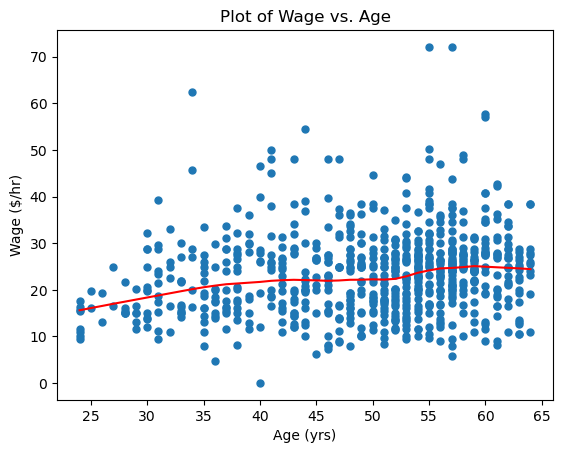

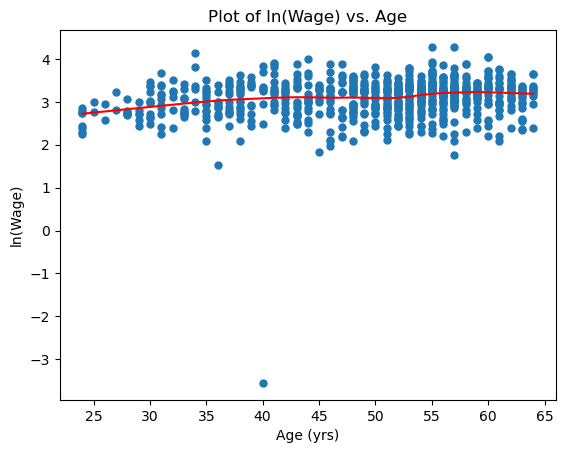

In [25]:
# Fig of Wage vs Age
plt.figure()
plt.scatter(data['age'],data['w'],s=25)
lowessfit1 = lowess(data['w'],data['age'],frac=1/3.0)
plt.plot(lowessfit1[:,0],lowessfit1[:,1],'r-')
plt.xlabel("Age (yrs)")
plt.ylabel("Wage ($/hr)")
plt.title("Plot of Wage vs. Age")
# Fig of ln(Wage) vs Age
plt.figure()
plt.scatter(data['age'],data['lnw'],s=25)
lowessfit2 = lowess(data['lnw'],data['age'],frac=1/3.0)
plt.plot(lowessfit2[:,0],lowessfit2[:,1],'r-')
plt.xlabel("Age (yrs)")
plt.ylabel("ln(Wage)")
plt.title("Plot of ln(Wage) vs. Age")

Both plots show that in the postal service, wages gradually increase in age. However, the lowess curve in the first plot suggests that wages tend to plateau between 40 and 50 years of age, before increasing again after that. Interestingly, while the data is generally clustered around the lowess curve, the ln(wage) vs age plot shows a clear outlier in the data. 

#### 1.3

In [26]:
# Add age**2 and age**3
data['age2'] = np.square(data['age'])
data['age3'] = np.power(data['age'],3)

C:\Users\2025\AppData\Local\Temp\ipykernel_25036\1914257646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age2'] = np.square(data['age'])
C:\Users\2025\AppData\Local\Temp\ipykernel_25036\1914257646.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age3'] = np.power(data['age'],3)


#### 1.4

In [38]:
cond = [
    (data['grade92'] <= 38),
    (data['grade92'] == 39),
    (data['grade92'] >= 40) & (data['grade92'] <= 42),
    (data['grade92'] == 43),
    (data['grade92'] >= 44)
]
vals = [0, 1, 2, 3, 4]
data.loc[:,'edu'] = np.select(cond,vals)

counts = data['edu'].value_counts(normalize=True,ascending=True)
print(counts.sort_index())


edu
0    0.017544
1    0.372470
2    0.431849
3    0.164642
4    0.013495
Name: proportion, dtype: float64


The majority (80.42%) of the workers in the postal service had either high completed high school or some college, with another 16.46% having a Bachelor's degree. However, very few postal workers had advanced degrees or hadn't completed high school. The general lack of advanced degrees in postal workers generally agrees with an assumption of not needing advanced skills or education in this field. However, seeing that the overwhelming majority had at least completed high school can likely be explained by that generally being a requirement for government jobs of this sort. 

## Question 2
#### 2.1

In [33]:

x1 = data['female']
x1 = sm.add_constant(x1)
y1 = data['lnw']
model1 = sm.OLS(y1,x1)
res1 = model1.fit()

x2 = data.loc[:,['female','age']]
x2 = sm.add_constant(x2)
y2 = data['lnw']
model2 = sm.OLS(y2,x2)
res2 = model2.fit()

x3 = data.loc[:,['female','age','age2']]
x3 = sm.add_constant(x3)
y3 = data['lnw']
model3 = sm.OLS(y3,x3)
res3 = model3.fit()

x4 = data.loc[:,['female','age','age2','age3']]
x4 = sm.add_constant(x4)
y4 = data['lnw']
model4 = sm.OLS(y4,x4)
res4 = model4.fit()

stargazer = Stargazer([res1, res2, res3, res4])
stargazer.covariate_order(['female','age','age2','age3','const'])
stargazer.custom_columns(['Model 1','Model 2','Model 3','Model 4'])
stargazer.dependent_variable_name('ln(wage)')
stargazer

a. For model 2, a coefficient of -0.130 for the female variable suggests that, on average, female postal workers make on average about 13% less than male postal workers. A cofficient of 0.008 for the age variable means that, on average, a postal worker makes 0.8% more for every year they are older. 

b. Out of these 4 models, model 2 is likely the most appropriate. Adding the $age^{2}$ and $age^{3}$ variables does not appear to substantially improve the predictive capacity of the model, with the $R^{2}$ values being nearly the same. Additionally, in model 2, the age coefficient is significant at 99% confidence while for models 3 and 4, all of the age coefficients are not significant. 

#### 2.2

In [39]:
x5 = data.loc[:,['female','edu']]
x5 = sm.add_constant(x5)
y5 = data['lnw']
model5 = sm.OLS(y5,x5)
res5 = model5.fit()

stargazer2 = Stargazer([res5])
stargazer2.covariate_order(['female','edu','const'])
stargazer2.custom_columns(['Model 5'])
stargazer2.rename_covariates({'edu' : 'Education', 'female':'Female','const':'Const'})
stargazer2.dependent_variable_name('ln(wage)')
stargazer2

In the model that examines the effect of gender and education on wages in the postal service, female postal workers, on average, make about 12.9% less then men (similar to the female and age regressions performed in part 2.1). In contrast, education is correlated with having a positive effect on the wages postal workers make. By moving up to the next highest category in the education coding (ex. from some college/completed high school to BA or from BA to advanced degrees), a postal worker is expected to, on average, see their wages increase by about 8.9%. 

#### 2.3

In [40]:
x6 = data.loc[:,['female','age','edu']]
x6 = sm.add_constant(x6)
y6 = data['lnw']
model6 = sm.OLS(y6,x6)
res6 = model6.fit()

stargazer3 = Stargazer([res1, res2, res6])
stargazer3.covariate_order(['female','age','edu','const'])
stargazer3.custom_columns(['Model 1','Model 2','Model 6'])
stargazer3.rename_covariates({'age': 'Age','edu' : 'Education', 'female':'Female','const':'Const'})
stargazer3.dependent_variable_name('ln(wage)')
stargazer3

As additional variables like education and age are included in the regression, the magnitude of the coefficient for the female variable tends to decrease. This suggests that for postal workers, there may be additional factors other than gender that influence the wage gap, with the gap going from 14.8% in model 1 to 11.1% in model 6, and that controlling for these other factors can help better estimate the actual gender wage gap. However, even in model 6, the coefficient for the female variable is still significant at 99% confidence, suggesting that gender does still play a factor in explaining the wage gap. 

#### 2.4

## Question 3

#### 3.1